# Networking between FIT and Grid'5000

Revisiting https://www.iot-lab.info/learn/tutorials/riot/riot-public-ipv6-m3/ in the context of mixed G5K/FIT resources.

---

- Website: https://discovery.gitlabpages.inria.fr/enoslib/index.html
- Instant chat: https://framateam.org/enoslib
- Source code: https://gitlab.inria.fr/discovery/enoslib
---

## Prerequisites:

<div class="alert alert-block alert-warning">
    Make sure you've run the one time setup for your environment (e.g one time setup for https://labs.iot-lab.info)
</div>

## Overview


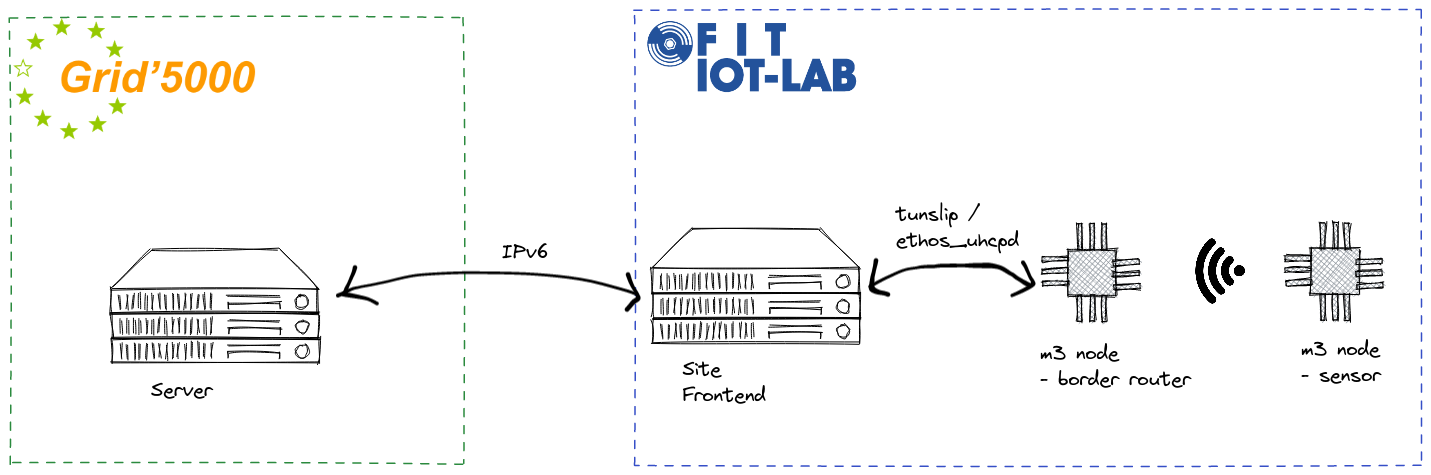

## FIT side

### Firmware compilations

In [ ]:
import os,binascii,random
pan_id = binascii.b2a_hex(os.urandom(2)).decode()
channel = random.randint(11, 26)
fit_site = random.choice(["grenoble", "lille"])

print(f"Use FIT_SITE={fit_site}, CHANNEL={channel}, PAN_ID=0x{pan_id}")

In [ ]:
# save the random parameters (allow to restart from here) 
FIT_SITE = CHANGEME!
%env CHANNEL = CHANGEME!
%env PAN_ID = CHANGEME!
%env ETHOS_BAUDRATE = 500000

In [ ]:
%env APP_DIR=../../riot/RIOT/examples/gnrc_border_router
!make -C $APP_DIR BOARD=iotlab-m3 DEFAULT_CHANNEL=$CHANNEL DEFAULT_PAN_ID=$PAN_ID && cp $APP_DIR/bin/iotlab-m3/*.elf .

In [ ]:
%env APP_DIR=../../riot/RIOT/examples/gnrc_networking
!make -C $APP_DIR BOARD=iotlab-m3 DEFAULT_CHANNEL=$CHANNEL DEFAULT_PAN_ID=$PAN_ID && cp $APP_DIR/bin/iotlab-m3/*.elf .

### Get some resources

Check the testbed status: https://www.iot-lab.info/testbed/status

In [ ]:
import enoslib as en

_ = en.init_logging()

In [ ]:
fit_conf = (
    en.IotlabConf.from_settings(job_name="riot_m3", walltime="01:00")
    .add_machine(roles=["border_router"], archi="m3:at86rf231", site=FIT_SITE, number=1, image="gnrc_border_router.elf")    
    .add_machine(roles=["other"], archi="m3:at86rf231", site=FIT_SITE, number=1, image="gnrc_networking.elf")    
)
fit_conf

# Hostname based
# fit_conf = (
#  en.IotlabConf.from_settings(job_name="riot_m3", walltime="02:00")
#  .add_machine(roles=["border_router"], hostname=["m3-62.grenoble.iot-lab.info"], image="gnrc_border_router.bin")   
#  .add_machine(roles=["other"], hostname=["m3-63.grenoble.iot-lab.info"], image="gnrc_border_router.bin")   
# ).finalize()
# fit_conf

In [ ]:
fit = en.Iotlab(fit_conf)
fit_roles, _ = fit.init()

In [ ]:
# keep track of the border router
br = fit_roles["border_router"][0]
br

In [ ]:
# This is useless at this point but practical in case you want to reflash your nodes at some point
fit.reset()

### Setting up IPv6

In [ ]:
import iotlabcli
iotlab_user, _ = iotlabcli.auth.get_user_credentials()
fit_frontend = en.Host("%s.iot-lab.info" % FIT_SITE, alias=FIT_SITE, user=iotlab_user) 

At this point you need to pick a free tap number and a [free subnet](https://www.iot-lab.info/legacy/tutorials/understand-ipv6-subnetting-on-the-fit-iot-lab-testbed/index.html)  

In [ ]:
r = en.run(f"ip -6 route", roles=fit_frontend)
print(r[0].stdout)

In [ ]:
# CHANGE ME!
tap = "tap44"
prefix = "2001:660:4403:0481"

In [ ]:
en.run(f"ps aux | grep {tap} | grep {iotlab_user}| grep -v grep | awk '{{print $2}}' | xargs -r kill", roles=fit_frontend)
r = en.run(f"sudo ethos_uhcpd.py {br.alias} {tap} {prefix}::1/64 2>&1 > ethos_uhcpd.out", roles=fit_frontend, background=True)

In [ ]:
r = en.run(f"ip -6 route", roles=fit_frontend)
print(r[0].stdout)

The other M3 device should get its IPv6 in the chosen after few seconds.
Retry the following until you get this IPv6 (or until you get bored)

Note that the command sends a command (`ifconfig`) to the other M3 device after SSH-ing to the frontend.

In [ ]:
other = fit_roles["other"][0]
r = en.run(f"echo ifconfig | nc -w1  {other.alias} 20000", fit_frontend)
print(r[0].stdout)

In [ ]:
# record this for future use
import re
m = re.findall(f'inet6 addr: (.*)  scope: global', r[0].stdout)
FIT_IPv6 = m[0]
FIT_IPv6

In [ ]:
# connectivity test with ... google
r = en.run(f"echo ping6 2001:4860:4860::8888 | nc -w5  {other.alias} 20000", fit_frontend)
print(r[0].stdout)

## Grid'5000 side

### Get some resources

You can check what's available here: https://www.grid5000.fr/w/Status

Some direct links:
- Gantt for nancy: https://intranet.grid5000.fr/oar/Nancy/drawgantt-svg/
- Gantt for rennes: https://intranet.grid5000.fr/oar/Rennes/drawgantt-svg/
- ...

In [ ]:
G5K_SITE = "rennes"
G5K_CLUSTER = "paravance"

network = en.G5kNetworkConf(type="prod", roles=["my_network"], site=G5K_SITE)

conf = (
    en.G5kConf.from_settings(job_type="allow_classic_ssh", job_name="fit_g5k_01_networking", walltime="01:00:00")
    .add_network_conf(network)
    .add_machine(
        roles=["server"], cluster=G5K_CLUSTER, nodes=1, primary_network=network
    )
    .finalize()
)
conf

In [ ]:
g5k = en.G5k(conf)
g5k_roles, g5k_networks = g5k.init()
g5k_roles

In [ ]:
g5k_networks

### Setting up IPv6

In [ ]:
en.run("dhclient -6 br0", roles=g5k_roles)    
r = en.run("ip a", g5k_roles)
print(r[0].stdout)

In [ ]:
# Change me! (manual change)
G5K_IPv6 = "2001:660:4406:700:1::31"

There are ways to retrieve the IP address automatically, let's review two of them:
- using the REST API (work for static IPs)
- using the library (cover use cases where IP are dynamically assigned)

In [ ]:
# The ip address can be retrieved from the REST API
from enoslib.infra.enos_g5k.g5k_api_utils import get_api_client

gk = get_api_client()
# grisou-1.nancy.grid5000.fr -> grisou-1
node_uid = g5k_roles["server"][0].alias.split(".")[0]
node = gk.sites[G5K_SITE].clusters[G5K_CLUSTER].nodes[node_uid]
print(node)

In [ ]:
# eth0 is the primary interface;
device = [ n for n in node.network_adapters if n["device"] == "eth0"][0]
device

In [ ]:
G5K_IPv6 = device["ip6"]
G5K_IPv6

In [ ]:
# Getting the IP automatically using the library
# First, do a sync of the description
# Second, filter the desired IP
g5k_roles = en.sync_info(g5k_roles, g5k_networks)
g5k_roles

In [ ]:
g5k_server = g5k_roles["server"][0]
addresses = g5k_server.filter_addresses(networks=g5k_networks["my_network"])
addresses

In [ ]:
from ipaddress import IPv6Interface
G5K_IPv6 = [str(a.ip.ip) for a in addresses if isinstance(a.ip, IPv6Interface)][0]
G5K_IPv6

## Cross traffic connectivity 

### Grid'5000 -> FIT

In [ ]:
r = en.run(f"ping -c 5 {FIT_IPv6}", roles=g5k_roles)
print(r[0].stdout)

### FIT -> Grid5000

In [ ]:
# open the firewall for the duration of the inner command
# opening a custom port will allow icmp traffic to flow
with g5k.firewall(proto="tcp+udp", port=80):
    r = en.run(f"echo ping6 {G5K_IPv6} | nc -w5  {other.alias} 20000", fit_frontend)
    print(r[0].stdout)

In [ ]:
# fails if the firewall isn't opened
r = en.run(f"echo ping6 {G5K_IPv6} | nc -w5  {other.alias} 20000", fit_frontend)
print(r[0].stdout)

## Clean up

In [ ]:
if g5k: 
    g5k.destroy()


In [ ]:
if fit:
    fit.destroy()